# Demo 2: Real-World Data

For this demo I use the `Hitters` dataset from the `ISLR` R package. This dataset contains data on 322 Major League Baseball players and their salaries during the 1986 and 1987 seasons.

The data is included in the `data/` directory within this repository. It can also be downloaded from the following link:  
https://raw.githubusercontent.com/selva86/datasets/master/Hitters.csv

I will demonstrate the capabilities of the `coorddescent`, `coorddescentCV`, and other supporting functions. I will use my code to predict players' salaries based on the rest of the information provided in the dataset.

## Package Imports and Initial Setup

In [1]:
import src.coorddescent as cd

import copy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import sklearn.preprocessing

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline

## Data Import and Standardization

The first step is to import the data and perform some initial cleanup, including dropping rows with missing data, splitting out the predictors and the response, and consolidating multi-column categorical variables into a single column where possible.

In [2]:
# import data and drop all rows that contain NA's
hitters = pd.read_csv('./data/Hitters.csv', sep=',', header=0)
hitters = hitters.dropna()

# split out predictors and response
X = hitters.drop('Salary', axis=1)
y = hitters['Salary']

# encode the variables League, Division, and NewLeague
X = pd.get_dummies(X, drop_first=True)

I split the data into a training set and a test set. The training set will be used to train the models; the test set will be excluded from the training process and therefore will act as "unseen" data for a final evaluation of model performance.

In [3]:
# train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

I center and standardize the predictors and the response. Centering allows me to exclude the intercept term from my equations (note: a predicted response of 0 corresponds to the mean of the predictors that were used to train the model).

Standardizing ensures that predictors with different scales do not dominate the minimization process, since the coefficients are included in the penalty terms. Note that I standardize the test set to the same scale as the training set (I have learned my lesson on this too many times).

In [4]:
# scale and center predictors
scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# scale and center response
y_train_mean = np.mean(y_train)
y_train_sd = np.std(y_train)
y_train = (y_train - y_train_mean) / y_train_sd
y_test = (y_test - y_train_mean) / y_train_sd

# save dimensions of training and test sets
n_train, p_train = X_train.shape
n_test, p_test = X_test.shape;

## Initial Implementation: $\lambda$ = 0.1

I now demonstrate the model fitting process using the `cd.coorddescent` function. I begin with default parameters $\lambda = 0.1$ and $\alpha = 0.9$. I run the model for both `cyclic` and `random` coordinate descent.

In [5]:
lam = 0.1
alpha = 0.9
betas_cyclic = cd.coorddescent(np.zeros(p_train), X_train, y_train, lam, alpha, desc_type="cyclic")
betas_random = cd.coorddescent(np.zeros(p_train), X_train, y_train, lam, alpha, desc_type="random", random_seed=0)

The `coorddescent` function returns the values of $\beta$ after every individual step (i.e. after every single minimization of a single coefficient coordinate). The plots below visualize the model fitting process for both the `cyclic` and `random` approaches. The first row shows the entire process for 1000 iterations for both approaches; the plots below zoom in on the action towards the beginning of the fitting process.

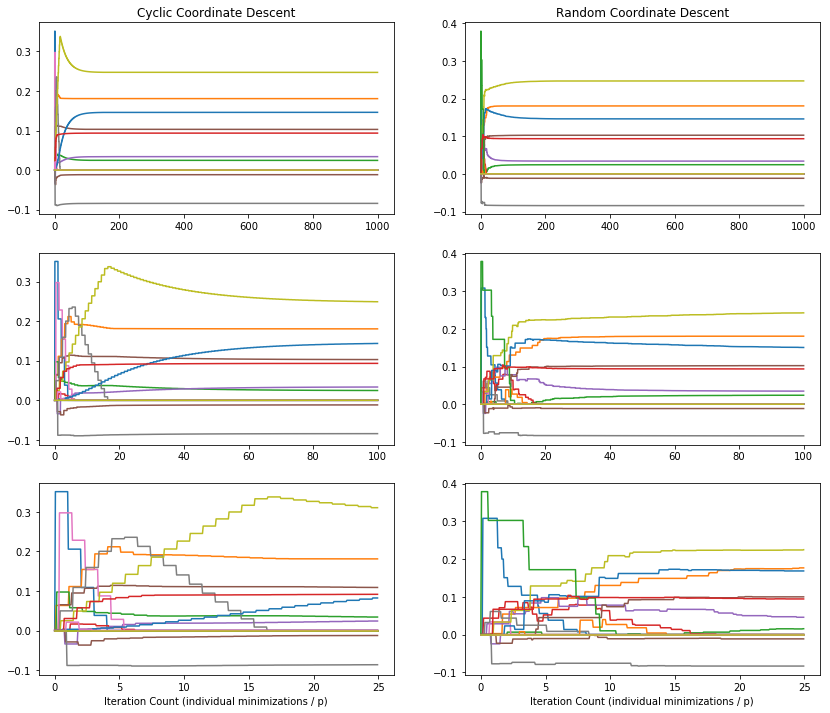

In [6]:
cd.plot_coefficient_steps(betas_cyclic, betas_random, [100, 25])

As shown, both methods appear to arrive at a stable solution after just 100 iterations or so. While both appear to arrive at similar solutions in the end, they do so in a very different manner. Not only is the random approach much more "jagged", but we also see several coefficients that take very different paths to the same end.

My code also includes a function called `compute_obj` which calculates the objective function value for a given $\beta$. I wrap this in a plotting function called `plot_obj_vals_steps` which I use to calculate the objective function value at each individual step and visualize the minimization process.

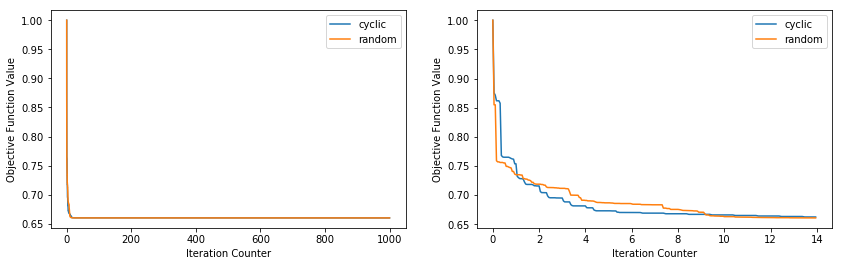

In [7]:
cd.plot_obj_vals_steps(betas_cyclic, betas_random, X_train, y_train, lam, alpha, 14)

As shown, the solutions for both methods approach the minimum after just a handful of iterations. The random method appears to approach the final solution a little quicker than the cyclic method out of the gate, but the latter overtakes the former after just one full iteration through all 19 coordinates. The random method catches up again after ~9 full iterations.

As a reference point, I calculate the mean squared error (MSE) for both approaches as compared to the `y_test` data.

In [8]:
pred_cyclic = X_test.dot(betas_cyclic[-1])
print("cyclic MSE = " + str(mean_squared_error(pred_cyclic, y_test)))

pred_random = X_test.dot(betas_random[-1])
print("random MSE = " + str(mean_squared_error(pred_random, y_test)))

cyclic MSE = 0.827256350447
random MSE = 0.827256350446


## Cross Validation

An important part of fitting any machine learning model is **cross-validation**. Cross-validation helps select appropriate tuning parameters to prevent over- or under-fitting a model to the training data.

Below I define an array of various values of $\lambda$ to try. I then call my `coorddescentCV` function which performs k-folds cross-validation and returns the MSE for each fold and each $\lambda$. I have decided to run 6 folds on just the cyclic coordinate method.

I then use the `plot_MSEs` function to visualize the results.

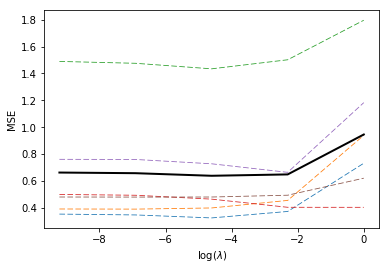

In [9]:
lambdas = np.array([10**k for k in range(-4, 1)])
all_MSEs = cd.coorddescentCV(X_train, y_train, lambdas, alpha, 6, random_seed=50)
cd.plot_MSEs(lambdas, all_MSEs)

In [10]:
lambdas
np.mean(all_MSEs, axis=0)
best_lam = cd.get_best_lambda(lambdas, all_MSEs)
print("best lambda =", best_lam)

array([  1.00000000e-04,   1.00000000e-03,   1.00000000e-02,
         1.00000000e-01,   1.00000000e+00])

array([ 0.66325166,  0.65846987,  0.63927811,  0.6493474 ,  0.94605719])

best lambda = 0.01


I now use my coordinate descent function to fit models on the Hitters dataset using the optimal $\lambda$ value I found through cross-validation in the previous bullet (i.e. 0.01). I perform this step for both cyclic and random methods.

In [11]:
betas_cyclic = cd.coorddescent(np.zeros(p_train), X_train, y_train, best_lam, alpha, desc_type="cyclic")
betas_random = cd.coorddescent(np.zeros(p_train), X_train, y_train, best_lam, alpha, desc_type="random", random_seed=0)

In [12]:
pred_cyclic = X_test.dot(betas_cyclic[-1])
print("cyclic MSE = " + str(mean_squared_error(pred_cyclic, y_test)))

pred_random = X_test.dot(betas_random[-1])
print("random MSE = " + str(mean_squared_error(pred_random, y_test)))

cyclic MSE = 0.749890354999
random MSE = 0.74989263179


Both of the MSEs above are lower than the MSEs I found in my initial attempt using an arbitrary $\lambda = 0.1$. This shows the importance of cross-validation! One might consider repeating the process above for different values of $\alpha$ as well.

Finally, I plot the predicted response against the actual test response. While not tight, we do see a loose linear relationship as we would expect. Also note that the predictions are essentially identical for the cyclic and random methods.

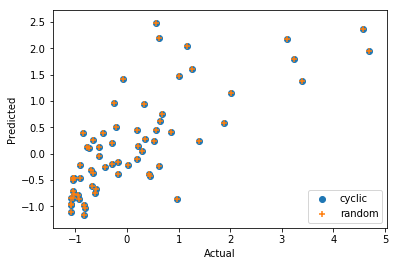

In [13]:
plt.scatter(y_test, X_test.dot(betas_cyclic[-1]));
plt.scatter(y_test, X_test.dot(betas_random[-1]), marker="+")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.legend(["cyclic", "random"], loc=4);